In [4]:
from datetime import date

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame, read_csv
from scipy.signal import argrelextrema

from rxtrade.data import add_amplitude_column, add_basic_columns
from rxtrade.utils import get_data_files

In [5]:
def get_data_df(ticker: str, file_path: str) -> DataFrame:
    df = read_csv(file_path)

    add_basic_columns(df)
    add_amplitude_column(ticker, df)

    df["Move (+10)"] = df["close"].shift(-10) - df["close"]

    df["Wave Min"] = df.iloc[argrelextrema(df["close"].values, np.less_equal, order=10)[0]]["close"]
    df["Wave Max"] = df.iloc[argrelextrema(df["close"].values, np.greater_equal, order=10)[0]]["close"]

    df["Volume 10 MA"] = df["Volume"].rolling(min_periods=10, window=10).mean() * 2
    df["Volume Burst"] = np.where(
        df["Volume"] > df["Volume 10 MA"],
        df["Volume"] / df["Volume 10 MA"],
        np.nan
    )

    # d = df.apply(lambda r: not np.isnan(r["Wave Min"]), axis=1)
    # df["Next Wave Min"] = d[d].idxmax().map(df["Wave Min"])

    # df["Volume Burst Entry Result"] = np.where(
    #     pd.notnull(df["Volume Burst"]),
    #     np.min(
    #         -38,
    #         np.where(df["open"] > df["close"], -1, 1),
    #     ),
    #     np.nan
    # )

    # Volume Burst
    # Cross over 60 EMA
    # EMAs reversal
    # EMAs backtest

    df[f"Body / Wick ({ticker})"] = abs(df["close"] - df["open"]) / abs(df["high"] - df["low"])
    return df

In [6]:
tickers = []
df = DataFrame(columns=["time"])

for data_file in get_data_files("./archive/futures/**/*.csv"):
    if data_file.period != 1:
        continue

    tickers.append(data_file.ticker)
    ticker_df = get_data_df(data_file.ticker, data_file.file_path)

    if len(df):
        df = df.merge(ticker_df, left_on="time", right_on="time")
    else:
        df = ticker_df


df

,time,open_x,high_x,low_x,close_x,Plot_x,MA #1_x,MA #2_x,MA #3_x,BB Basis_x,...,Market Date,Market Hour,Market Code,Amplitude (YM),Move (+10),Wave Min,Wave Max,Volume 10 MA,Volume Burst,Body / Wick
0,2022-01-16 17:00:00-06:00,4666.00,4671.75,4664.00,4667.00,4667.583333,NaN,NaN,NaN,NaN,...,2022-01-17,17,E,NaN,-37.0,NaN,NaN,NaN,NaN,0.250000
1,2022-01-16 17:01:00-06:00,4666.75,4669.00,4666.25,4668.50,4667.704608,NaN,NaN,NaN,NaN,...,2022-01-17,17,E,15.0,-33.0,NaN,35883.0,NaN,NaN,0.720000
2,2022-01-16 17:02:00-06:00,4668.75,4669.00,4665.50,4666.50,4667.608905,NaN,NaN,NaN,NaN,...,2022-01-17,17,E,13.0,6.0,NaN,NaN,NaN,NaN,0.483871
3,2022-01-16 17:03:00-06:00,4666.50,4667.00,4664.25,4665.25,4667.318743,NaN,NaN,NaN,NaN,...,2022-01-17,17,E,7.0,4.0,NaN,NaN,NaN,NaN,0.350000
4,2022-01-16 17:04:00-06:00,4665.00,4665.00,4661.50,4663.75,4666.474462,4666.200000,NaN,NaN,NaN,...,2022-01-17,17,E,13.0,2.0,NaN,NaN,NaN,NaN,0.360000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13545,2022-01-28 15:55:00-06:00,4421.75,4422.00,4420.25,4420.50,4345.491292,4420.880714,4420.977394,4415.356017,4421.3375,...,2022-01-28,15,E,8.0,NaN,NaN,NaN,70.2,NaN,1.000000
13546,2022-01-28 15:56:00-06:00,4420.25,4420.75,4420.00,4420.00,4345.497815,4420.587143,4420.799686,4415.508279,4421.3250,...,2022-01-28,15,E,0.0,NaN,NaN,NaN,70.4,NaN,0.500000
13547,2022-01-28 15:57:00-06:00,4420.25,4420.75,4419.75,4420.25,4345.510822,4420.474762,4420.699743,4415.663745,4421.2750,...,2022-01-28,15,E,5.0,NaN,NaN,NaN,69.6,NaN,0.800000
13548,2022-01-28 15:58:00-06:00,4420.25,4420.50,4419.50,4420.50,4345.526895,4420.483175,4420.663426,4415.822311,4421.2750,...,2022-01-28,15,E,2.0,NaN,NaN,NaN,84.6,NaN,0.142857


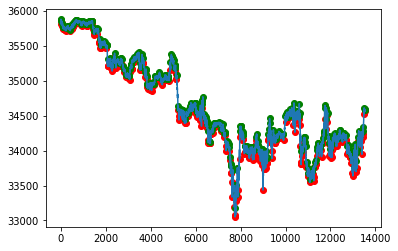

In [7]:
plt.scatter(df.index, df["Wave Min"], c="r")
plt.scatter(df.index, df["Wave Max"], c="g")
plt.plot(df.index, df["close"])
plt.show()